# Machine Learning Intrusion Detection System
## Binary Classification on NSL-KDD Dataset

In this project, we compare three machine learning models for network intrusion detection:
- Logistic Regression
- Decision Tree
- Random Forest

The goal is to determine which model provides the best balance of accuracy and computational efficiency for practical deployment.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import time


## Data Loading

NSL-KDD dataset, commonly used for intrusion detection research. It contains 41 features describing network connections and a label indicating normal traffic or attack type.


In [37]:
# Download NSL-KDD dataset
train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"
test_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt"

# Define column names
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

train_df = pd.read_csv(train_url, names=col_names)
test_df = pd.read_csv(test_url, names=col_names)

print(f"Training samples: {train_df.shape[0]}")
print(f"Test samples: {test_df.shape[0]}")
print(f"Features: {train_df.shape[1] - 2}")  # Exclude 'class' and 'difficulty'


Training samples: 125973
Test samples: 22544
Features: 41


In [38]:
# Check class distribution
print("\nTraining set class distribution:")
print(train_df['class'].value_counts())

train_df.head()


Training set class distribution:
class
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## Data Preprocessing

We convert the problem to binary classification: normal traffic (0) vs any attack (1). Categorical features (protocol_type, service, flag) are one-hot encoded, and numeric features are standardized using StandardScaler.


In [39]:
# Binary classification: normal vs attack
train_df['binary_class'] = train_df['class'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['binary_class'] = test_df['class'].apply(lambda x: 0 if x == 'normal' else 1)

# One-hot encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align columns between train and test
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

# Separate features and labels
X_train = train_encoded.drop(['class', 'binary_class', 'difficulty'], axis=1)
y_train = train_encoded['binary_class']
X_test = test_encoded.drop(['class', 'binary_class', 'difficulty'], axis=1)
y_test = test_encoded['binary_class']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Preprocessed feature dimensions: {X_train_scaled.shape}")
print(f"Training class balance: {y_train.value_counts().to_dict()}")


Preprocessed feature dimensions: (125973, 119)
Training class balance: {0: 67343, 1: 58630}


## Model Training

We train three models with default parameters:
1. **Logistic Regression** - Linear baseline
2. **Decision Tree** - Non-linear, interpretable
3. **Random Forest** - Ensemble method


In [40]:
models = {}
train_times = {}

# Logistic Regression
print("Training Logistic Regression...")
start = time.time()
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
train_times['Logistic Regression'] = time.time() - start
models['Logistic Regression'] = logreg

# Decision Tree
print("Training Decision Tree...")
start = time.time()
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_scaled, y_train)
train_times['Decision Tree'] = time.time() - start
models['Decision Tree'] = tree

# Random Forest
print("Training Random Forest...")
start = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
train_times['Random Forest'] = time.time() - start
models['Random Forest'] = rf

print("\nAll models trained successfully.")


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...

All models trained successfully.


In [41]:
# Save trained models
joblib.dump(logreg, 'logreg_model.pkl')
joblib.dump(tree, 'tree_model.pkl')
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Models saved.")


Models saved.


## Model Evaluation

We evaluate each model on the test set using multiple metrics:
- **Accuracy**: Overall correctness
- **Precision**: Fraction of predicted attacks that are actual attacks
- **Recall**: Fraction of actual attacks detected
- **F1-Score**: Harmonic mean of precision and recall


In [42]:
results = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Training Time (s)': round(train_times[name], 2)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('model_comparison.csv', index=False)


              Model  Accuracy  Precision   Recall  F1-Score  Training Time (s)
      Decision Tree  0.798217   0.964975 0.669836  0.790764               1.74
      Random Forest  0.775328   0.968290 0.625808  0.760259               9.85
Logistic Regression  0.752573   0.917002 0.621601  0.740944              14.65


## Confusion Matrices

Confusion matrices show the breakdown of correct and incorrect predictions for each model.


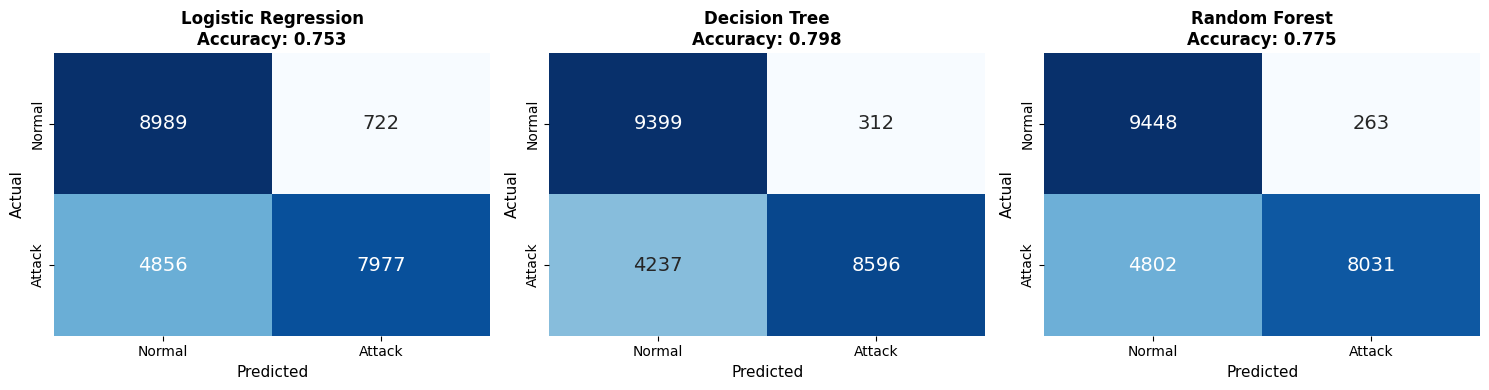

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues',
                cbar=False, annot_kws={'size': 14})
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred):.3f}',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11)
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_xticklabels(['Normal', 'Attack'])
    axes[idx].set_yticklabels(['Normal', 'Attack'])

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()


## Performance Comparison

Below we visualize the trade-offs between different metrics across models.


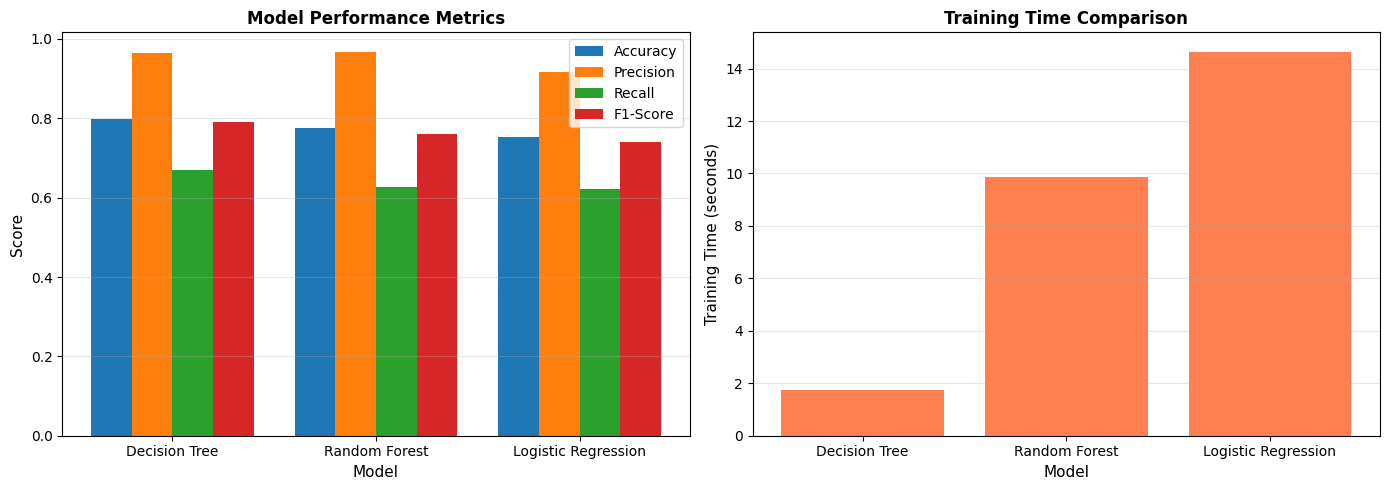

In [44]:
# Plot metric comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy, Precision, Recall, F1
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    ax[0].bar(x + i*width, results_df[metric], width, label=metric)

ax[0].set_xlabel('Model', fontsize=11)
ax[0].set_ylabel('Score', fontsize=11)
ax[0].set_title('Model Performance Metrics', fontsize=12, fontweight='bold')
ax[0].set_xticks(x + width * 1.5)
ax[0].set_xticklabels(results_df['Model'], rotation=0)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Training time comparison
ax[1].bar(results_df['Model'], results_df['Training Time (s)'], color='coral')
ax[1].set_xlabel('Model', fontsize=11)
ax[1].set_ylabel('Training Time (seconds)', fontsize=11)
ax[1].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')
plt.show()


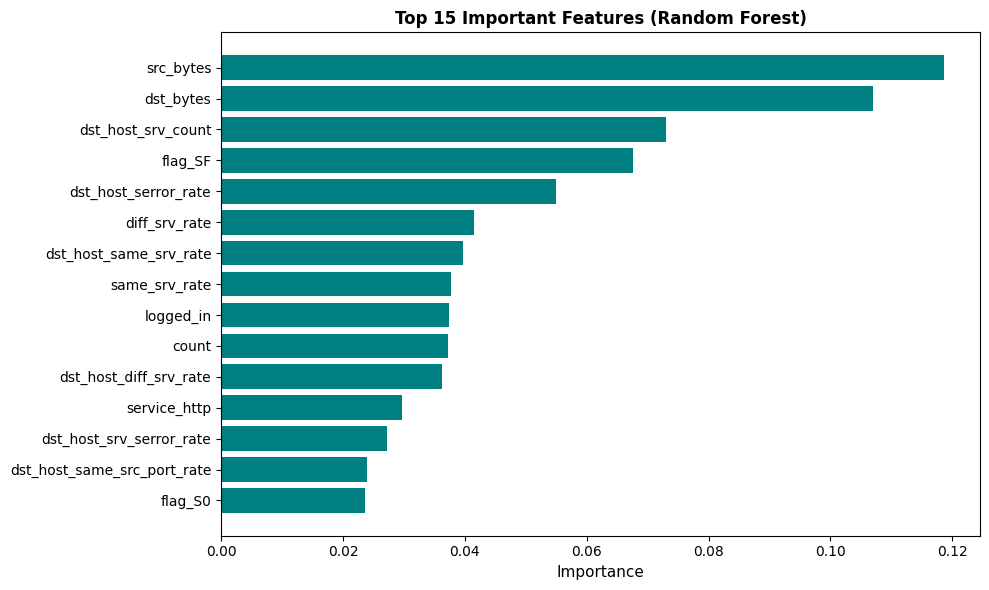

In [45]:
# Feature importance from Random Forest
feature_names = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], color='teal')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance', fontsize=11)
plt.title('Top 15 Important Features (Random Forest)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
